**Experiment Configs**

- `huggingface_model_name`: should be a model name from the HuggingFace model hub. For example, `facebook/opt-2.7b`.
- `huggingface_token`: should be a HuggingFace API token. Only is used when you use some models like `Llama2`.
- `quantization`: should be a boolean value. If it is `True`, the model will be quantized.
- `dataset_name`: should be a dataset name from the given examples: `"SemEvalR", "SemEvalL", "poem_sentiment", "TEE", "TEH", "TES", "FP", "AGNews", "MR", "hate_speech"`
- `k`: the demonstration numbers for the ICL.
- `calibration_sample_number_for_each_label`: the number of samples for calibration w.r.t. each label category for some of the calibration methods. i.e. the horizontal axis of the Fig. 6 in the paper.

In [ ]:
# Configs
huggingface_model_name = "facebook/opt-2.7b"
huggingface_token = "API_TOKEN"
quantization = False

dataset_name = "SemEvalR" # Alternative: "SemEvalR", "SemEvalL", "poem_sentiment", "TEE", "TEH", "TES", "FP", "AGNews", "MR", "hate_speech"

k = 6
calibration_sample_number_for_each_label = 16

**Load everything.**

In [ ]:
# Import libraries, and nessessary definitions

import sys
sys.path.append("hidden_calibration_released") # Replace with the path from the working directory to the root of this project. If the working directory is already the root of the project, this line is not needed.

import util.prompting as prompting
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import util.dataset_loader as dataset_loader
import util.calibrations as calibrations
import numpy as np
from tqdm import tqdm
from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score
from scipy import spatial
import copy
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

dataset_name_to_class = {
    "SemEvalR": dataset_loader.SemEval2014_Restaurants,
    "SemEvalL": dataset_loader.SemEval2014_Laptops,
    "poem_sentiment": dataset_loader.poem_sentiment,
    "TEE": dataset_loader.tweet_eval_emotion,
    "TEH": dataset_loader.tweet_eval_hate,
    "TES": dataset_loader.tweet_eval_sentiment,
    "FP": dataset_loader.financial_phrasebank,
    "AGNews": dataset_loader.agnews,
    "MR": dataset_loader.rooten_tomato,
    "hate_speech": dataset_loader.hate_speech18,
}

plt.style.use('default')
plt.rc('font',family='Times New Roman')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
# Load model and tokenizer from Huggingface

torch.cuda.empty_cache()

tokenizer = AutoTokenizer.from_pretrained(huggingface_model_name, token = huggingface_token)
if quantization:
    model = AutoModelForCausalLM.from_pretrained(huggingface_model_name, token = huggingface_token, quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    ))
else:
    model = AutoModelForCausalLM.from_pretrained(huggingface_model_name, token = huggingface_token).cuda()

/home/s2320415/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_data = dataset_name_to_class[dataset_name]().default_training_division()
test_data = dataset_name_to_class[dataset_name]().default_testing_division()
if dataset_name == "AGNews":
    train_data.cut_by_length(226)
    test_data.cut_by_length(226)

**Train all the calibration methods.**

In [39]:
# Train the Contextual Calibration and Domain Calibration

torch.cuda.empty_cache()
observed_background_prob_for_CC = calibrations.empty_query_base_logits(model, tokenizer, train_data, k, calibration_sample_number_for_each_label * len(train_data.label_space))
observed_background_prob_for_DC = calibrations.domain_text_base_logits(model, tokenizer, train_data, k, calibration_sample_number_for_each_label * len(train_data.label_space))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.75it/s]


In [42]:
# Train the Hidden Calibration

## Collect the hidden states for the calibration samples.
ground_truth_labels_for_calibration_samples = []
observed_full_vocabulary_probabilities = []
observed_last_hidden_state = []

torch.no_grad()
for j in range(len(train_data.label_space)):
    label_set = dataset_loader.get_label_set_from_label_index(train_data, j)
    for i in tqdm(label_set[:calibration_sample_number_for_each_label]):
        torch.cuda.empty_cache()
        prpt = prompting.default_prompting(train_data, k, query_index=i)
        tknzd_data = tokenizer(prpt[0], return_tensors="pt").input_ids.cuda()
        result = model(tknzd_data, output_hidden_states = True)
        result_vector = result['logits'][0][-1].detach().cpu().numpy()
        one_last_hidden_state = result.hidden_states[-1][-1][-1].detach().cpu().numpy()
        observed_last_hidden_state.append(one_last_hidden_state)
        tkized_label_space = []
        ground_truth_labels_for_calibration_samples.append(train_data.label_space.index(prpt[1]))

## Divide the collected hidden states by label.
observed_last_hidden_state_indexed_by_label = []

for label in train_data.label_space:
    observed_last_hidden_state_indexed_by_label.append([])
for i in range(len(ground_truth_labels_for_calibration_samples)):
    observed_last_hidden_state_indexed_by_label[ground_truth_labels_for_calibration_samples[i]].append(observed_last_hidden_state[i])

## Calculate the centroids from the collected hidden states
observed_last_hidden_state_CENTROID_indexed_by_label = []
for lists in observed_last_hidden_state_indexed_by_label:
    observed_last_hidden_state_CENTROID_indexed_by_label.append(np.mean(lists, axis=0))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.38it/s]


In [44]:
logits_set_wrt_label = []
hidden_set_wrt_label = []
con_set_wrt_label = []
dom_set_wrt_label = []
for i in range(len(train_data.label_space)):
    logits_set_wrt_label.append([])
    hidden_set_wrt_label.append([])

In [45]:
count = 0
acc_distance = 0
acc_dir = 0

torch.no_grad()
for i in tqdm(range(test_data.get_max())):
    count += 1
    torch.cuda.empty_cache()
    predicted_single = []
    prpt = prompting.default_prompting(test_data, k, query_index=i)
    tknzd_data = tokenizer(prpt[0], return_tensors="pt").input_ids.cuda()
    result = model(tknzd_data, output_hidden_states = True)
    result_vector = result['logits'][0][-1].detach().cpu().numpy()
    ahidden_state = result.hidden_states[-1][-1][-1].detach().cpu().numpy()
    direct_label_logits = []
    # hidden_set_wrt_label[test_data.label_space.index(prpt[1])].append(ahidden_state)
    
    for label in test_data.label_space:
        index = tokenizer(label).input_ids[-1]
        direct_label_logits.append(result_vector[index])
    direct_label_logits = softmax(direct_label_logits)
    logits_set_wrt_label[test_data.label_space.index(prpt[1])].append(direct_label_logits)
    
    if test_data.label_space.index(prpt[1]) == np.argmax(direct_label_logits):
        acc_dir += 1
    
    distance_label_logits = []
    for j in range(len(train_data.label_space)):
        distance_label_logits.append(-spatial.distance.euclidean(ahidden_state, observed_last_hidden_state_CENTROID_indexed_by_label[j]) + 15)
    hidden_set_wrt_label[test_data.label_space.index(prpt[1])].append(softmax(distance_label_logits))
    
    if test_data.label_space.index(prpt[1]) == np.argmax(distance_label_logits):
        acc_distance += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:53<00:00,  4.51it/s]


In [48]:
logits_results = []
hidden_results = []
con_results = []
dom_results = []
logits_for_avg = []
hidden_for_avg = []
con_for_avg = []
dom_for_avg = []

for i in range(len(train_data.label_space)):
    logits_results.append([0] * len(train_data.label_space))
    hidden_results.append([0] * len(train_data.label_space))
    con_results.append([0] * len(train_data.label_space))
    dom_results.append([0] * len(train_data.label_space))

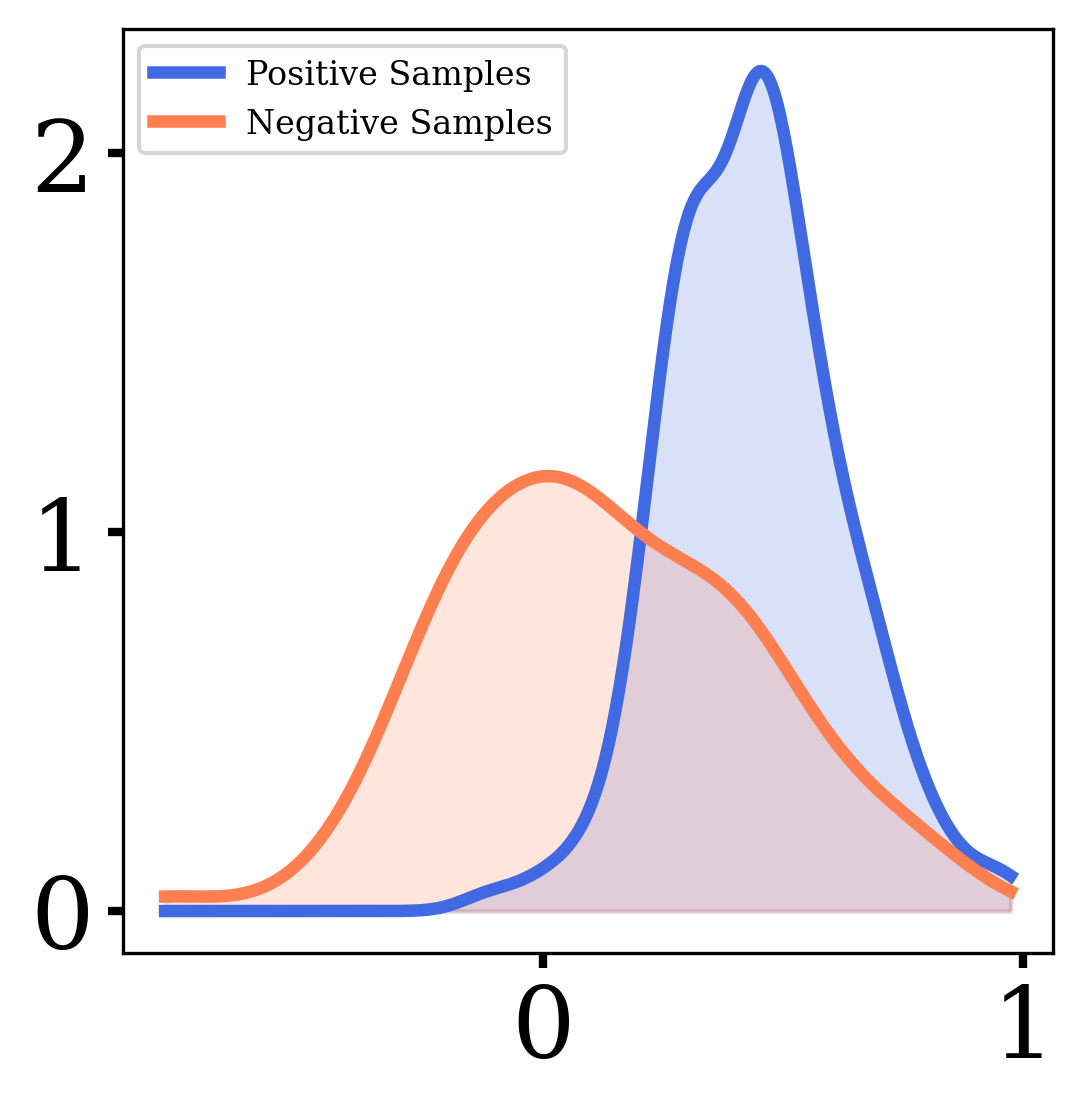

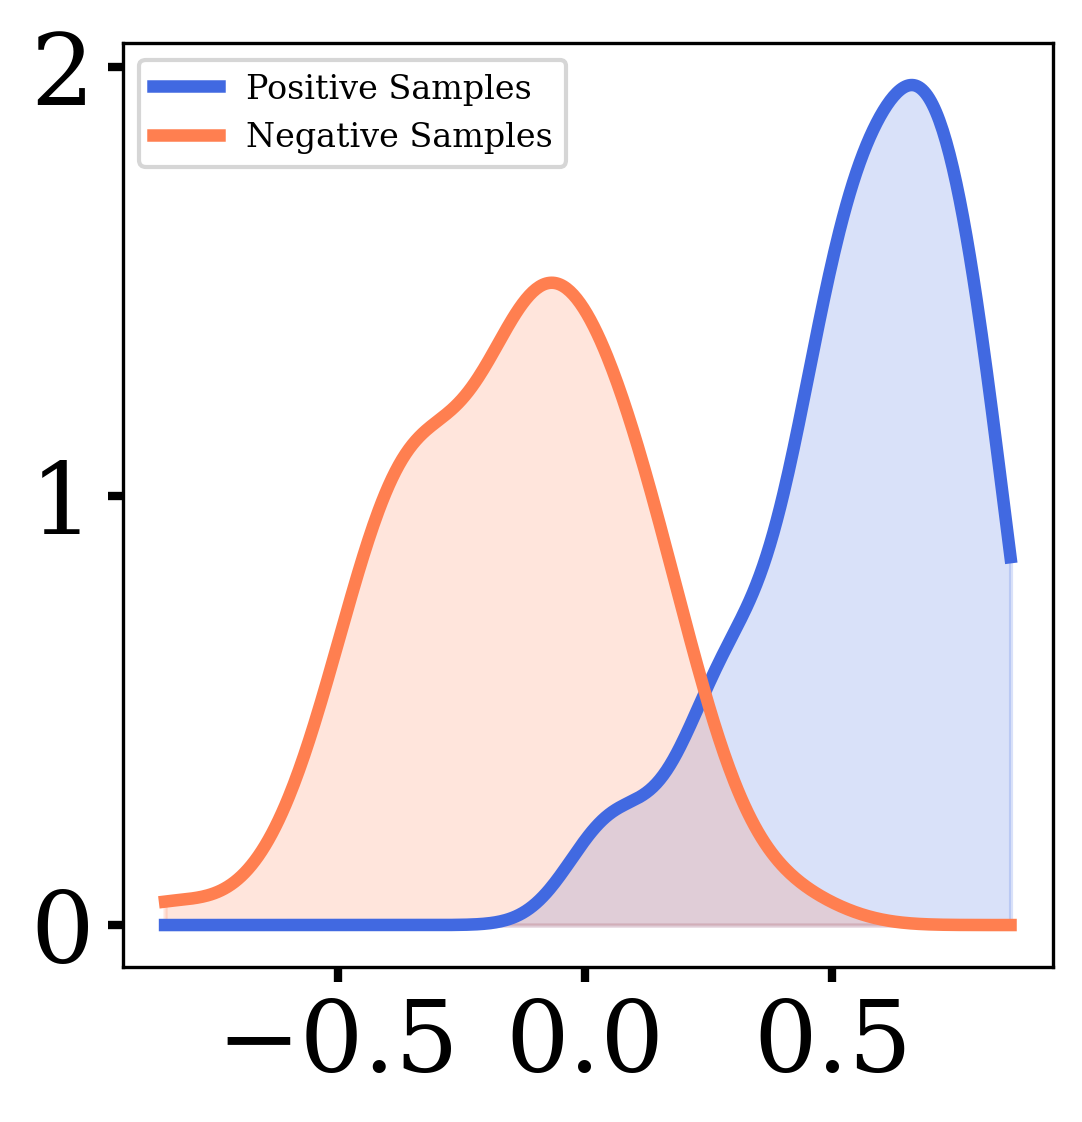

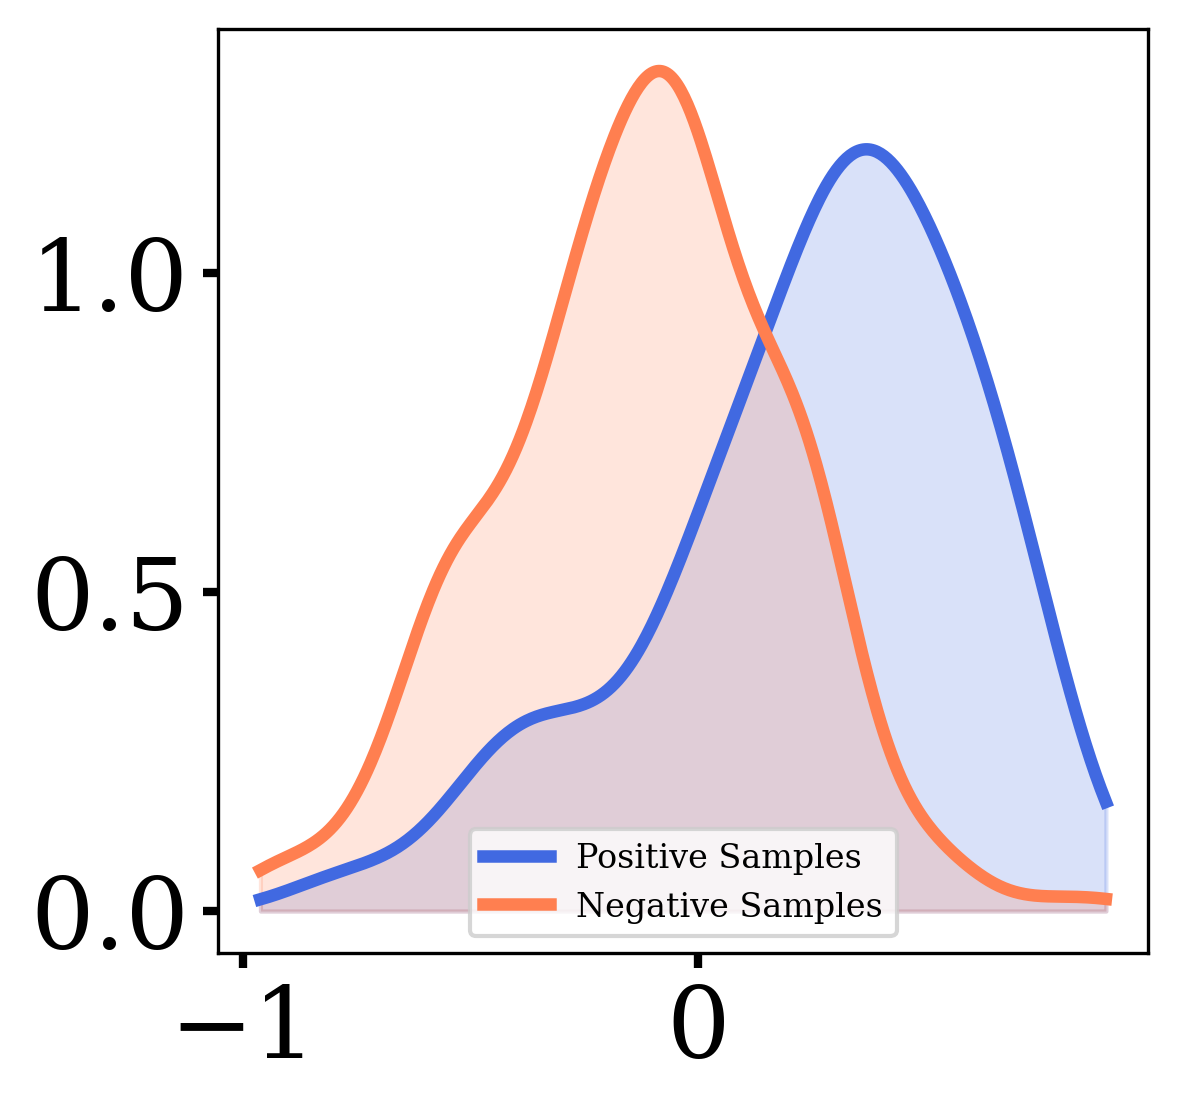

In [50]:
for i in range(len(train_data.label_space)):
    # logits_results[i][i] = 1
    for j in range(i):
        logist_distribution_labeli = []
        logist_distribution_labelj = []
        for res in logits_set_wrt_label[i]:
            logist_distribution_labeli.append(res[i] - res[j])
        for res in logits_set_wrt_label[j]:
            logist_distribution_labelj.append(res[i] - res[j])
        density1 = gaussian_kde(logist_distribution_labeli)
        density2 = gaussian_kde(logist_distribution_labelj)
        x = np.linspace(min(min(logist_distribution_labeli), min(logist_distribution_labelj)), 
                        max(max(logist_distribution_labeli), max(logist_distribution_labelj)), 500)
        overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
        logits_results[i][j] = overlap_area
        logits_for_avg.append(overlap_area)
        
        plt.figure(figsize=(4, 4), dpi=300)
        plt.plot(x, density1(x), 
                 label='Positive Samples', 
                 color='Royalblue',
                 linewidth = 3)
        plt.plot(x, density2(x), 
                 label='Negative Samples', 
                 color='Coral',
                 linewidth = 3)
        plt.fill_between(x, density1(x), 0, color='Royalblue', alpha=0.2)
        plt.fill_between(x, density2(x), 0, color='Coral', alpha=0.2)
        # plt.xlabel("Probability: Pos. - Neg.", fontsize=16)
        # plt.ylabel("Kernel Density", fontsize=20)
        plt.legend(prop = {'size': 8})
        plt.tick_params(width=2, labelsize=24)
        # plt.savefig("Ana1, fig/direct/" + train_data.dataset_name + str(k) + '-' + str(i) + '-' + str(j) + '.png', bbox_inches = 'tight')
        plt.show()

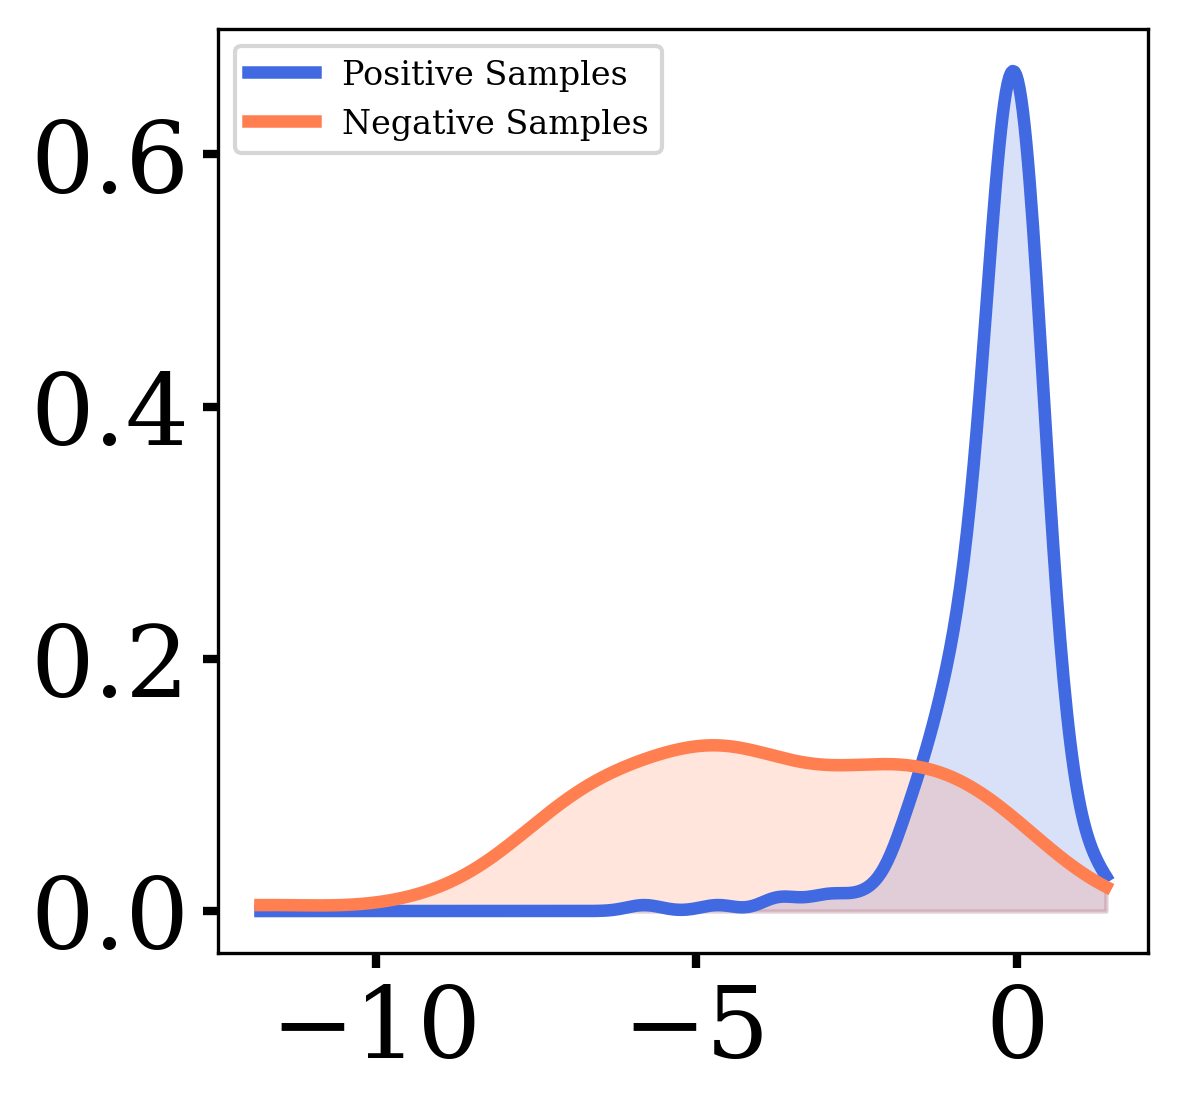

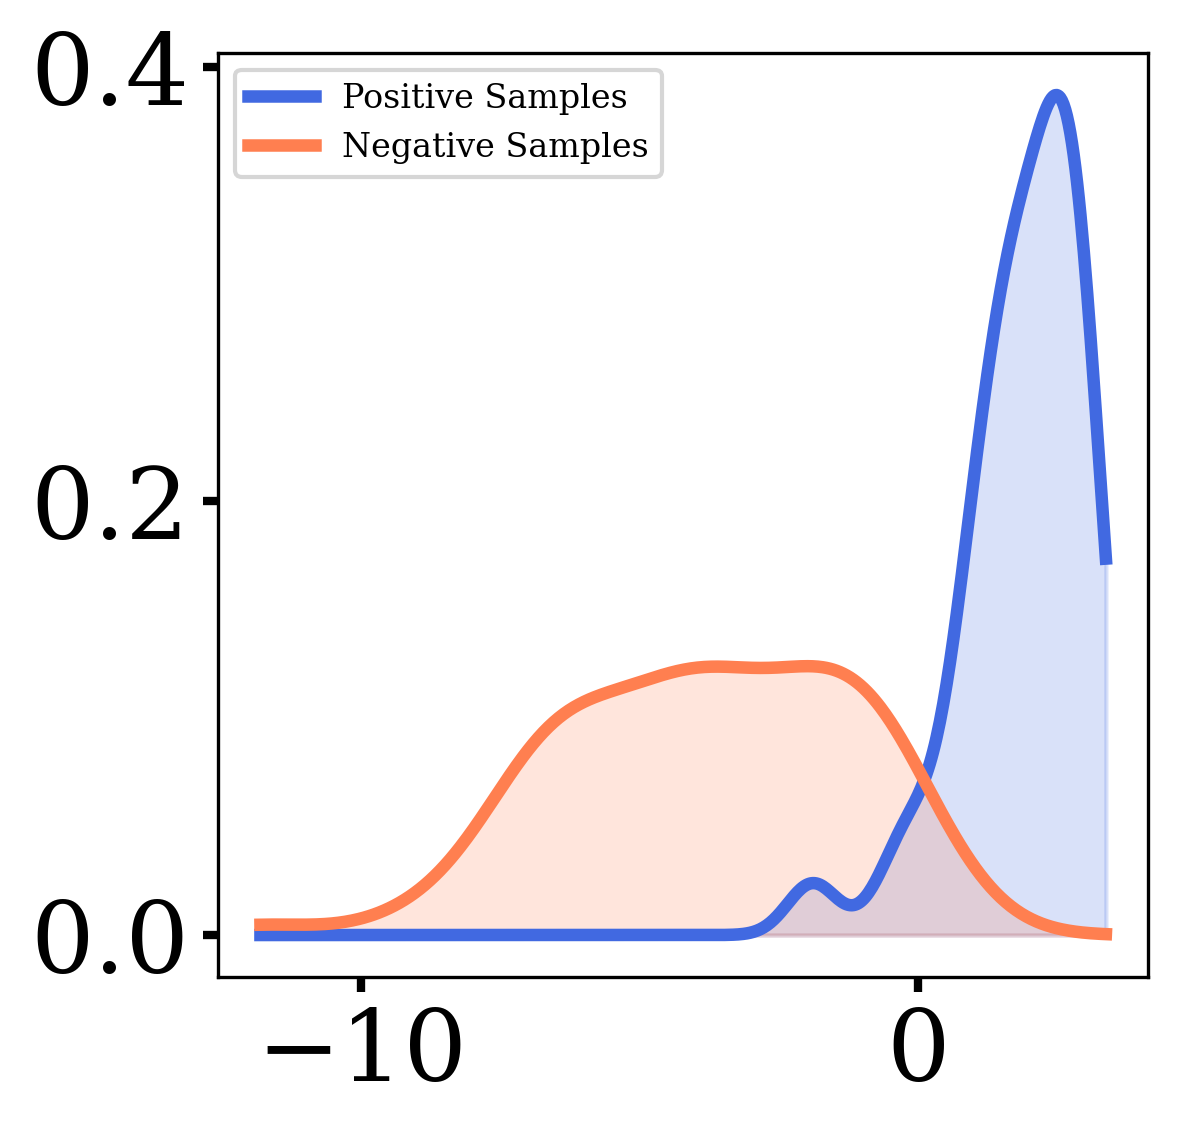

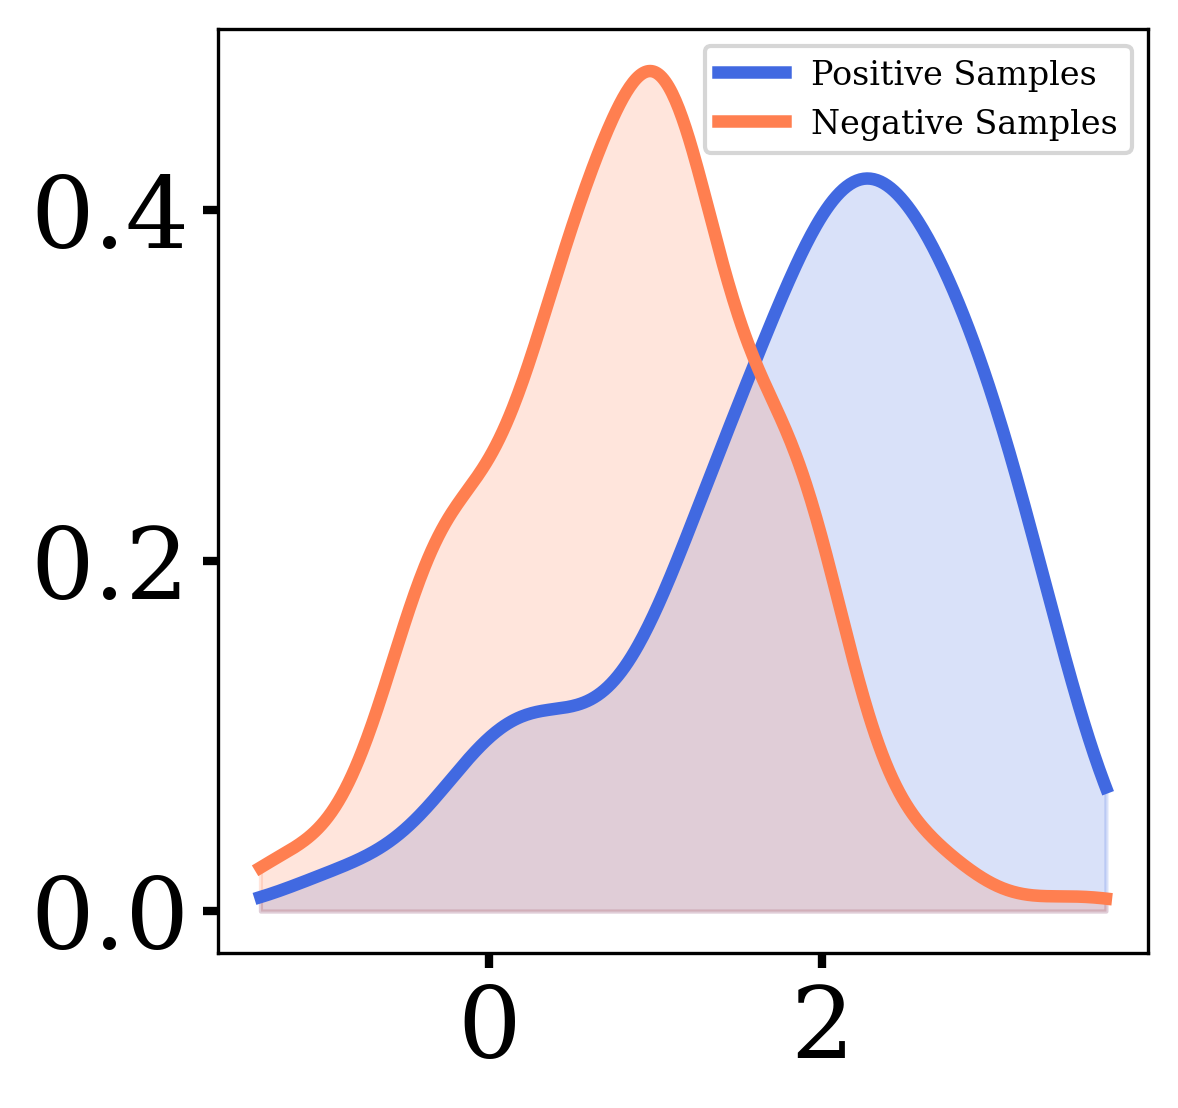

In [51]:
for i in range(len(train_data.label_space)):
    # hidden_results[i][i] = 1
    for j in range(i):
        con_distribution_labeli = []
        con_distribution_labelj = []
        for res in logits_set_wrt_label[i]:
            con_distribution_labeli.append(res[i] / observed_background_prob_for_CC[i] - res[j] / observed_background_prob_for_CC[j])
        for res in logits_set_wrt_label[j]:
            con_distribution_labelj.append(res[i] / observed_background_prob_for_CC[i] - res[j] / observed_background_prob_for_CC[j])
        density1 = gaussian_kde(con_distribution_labeli)
        density2 = gaussian_kde(con_distribution_labelj)
        x = np.linspace(min(min(con_distribution_labeli), min(con_distribution_labelj)), 
                        max(max(con_distribution_labeli), max(con_distribution_labelj)), 500)
        overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
        con_results[i][j] = overlap_area
        con_for_avg.append(overlap_area)
        
        plt.figure(figsize=(4, 4), dpi=300)
        plt.plot(x, density1(x), 
                 label='Positive Samples', 
                 color='Royalblue',
                 linewidth = 3)
        plt.plot(x, density2(x), 
                 label='Negative Samples', 
                 color='Coral',
                 linewidth = 3)
        plt.fill_between(x, density1(x), 0, color='Royalblue', alpha=0.2)
        plt.fill_between(x, density2(x), 0, color='Coral', alpha=0.2)
        # plt.xlabel("Probability: Pos. - Neg.", fontsize=16)
        # plt.ylabel("Kernel Density", fontsize=20)
        plt.legend(prop = {'size': 8})
        plt.tick_params(width=2, labelsize=24)
        # plt.savefig("Ana1, fig/con/" + train_data.dataset_name + str(k) + '-' + str(i) + '-' + str(j) + '.png', bbox_inches = 'tight')
        plt.show()

# from scipy import spatial

# for i in range(len(train_data.label_space)):
#     # hidden_results[i][i] = 1
#     for j in range(i):
#         hidden_distribution_labeli = []
#         hidden_distribution_labelj = []
#         for res in hidden_set_wrt_label[i]:
#             hidden_distribution_labeli.append(spatial.distance.euclidean(res, hiddenwrtlabels_avg[j]) - spatial.distance.euclidean(res, hiddenwrtlabels_avg[i]))
#         for res in hidden_set_wrt_label[j]:
#             hidden_distribution_labelj.append(spatial.distance.euclidean(res, hiddenwrtlabels_avg[i]) - spatial.distance.euclidean(res, hiddenwrtlabels_avg[j]))
#         density1 = gaussian_kde(hidden_distribution_labeli)
#         density2 = gaussian_kde(hidden_distribution_labelj)
#         x = np.linspace(min(hidden_distribution_labeli), max(hidden_distribution_labelj), 500)
#         overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
#         hidden_results[i][j] = overlap_area
#         plt.plot(x, density1(x), label='Data 1')
#         plt.plot(x, density2(x), label='Data 2')
#         plt.fill_between(x, density1(x), density2(x), where=(density1(x) > density2(x)), color='green', alpha=0.3)
#         plt.fill_between(x, density1(x), density2(x), where=(density1(x) < density2(x)), color='red', alpha=0.3)
#         plt.legend()
#         plt.show()

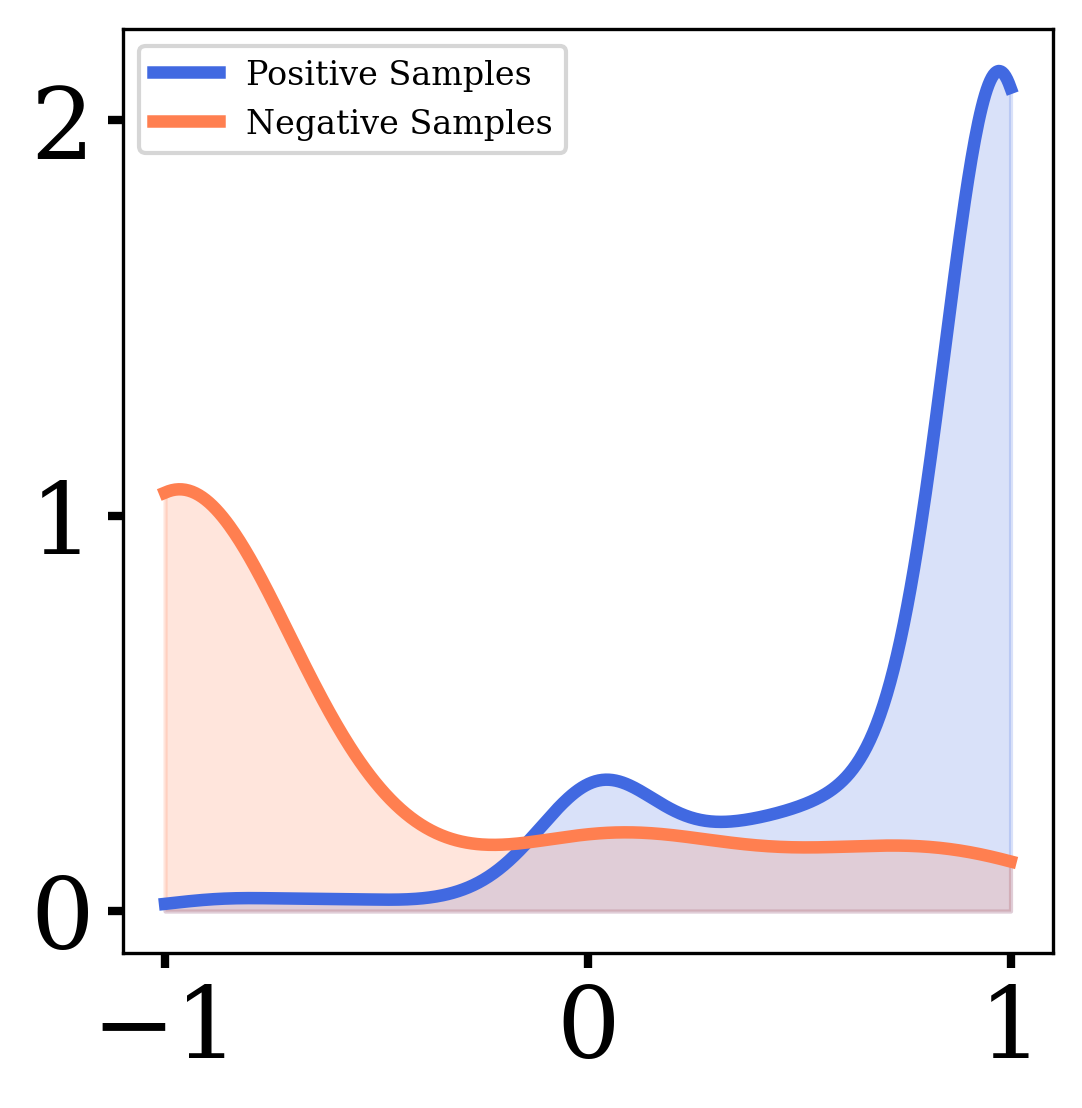

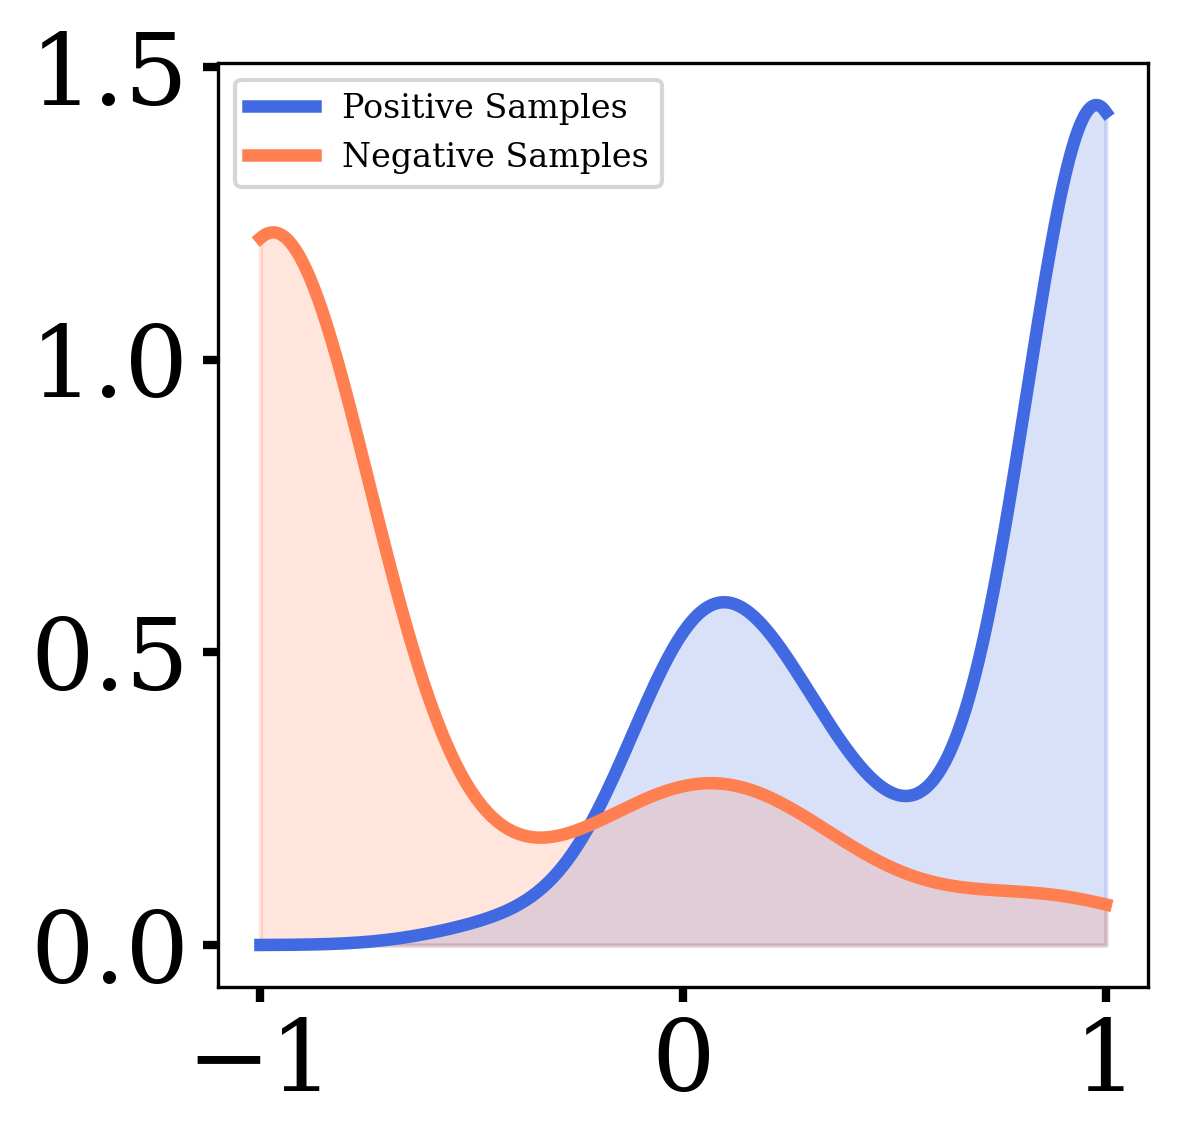

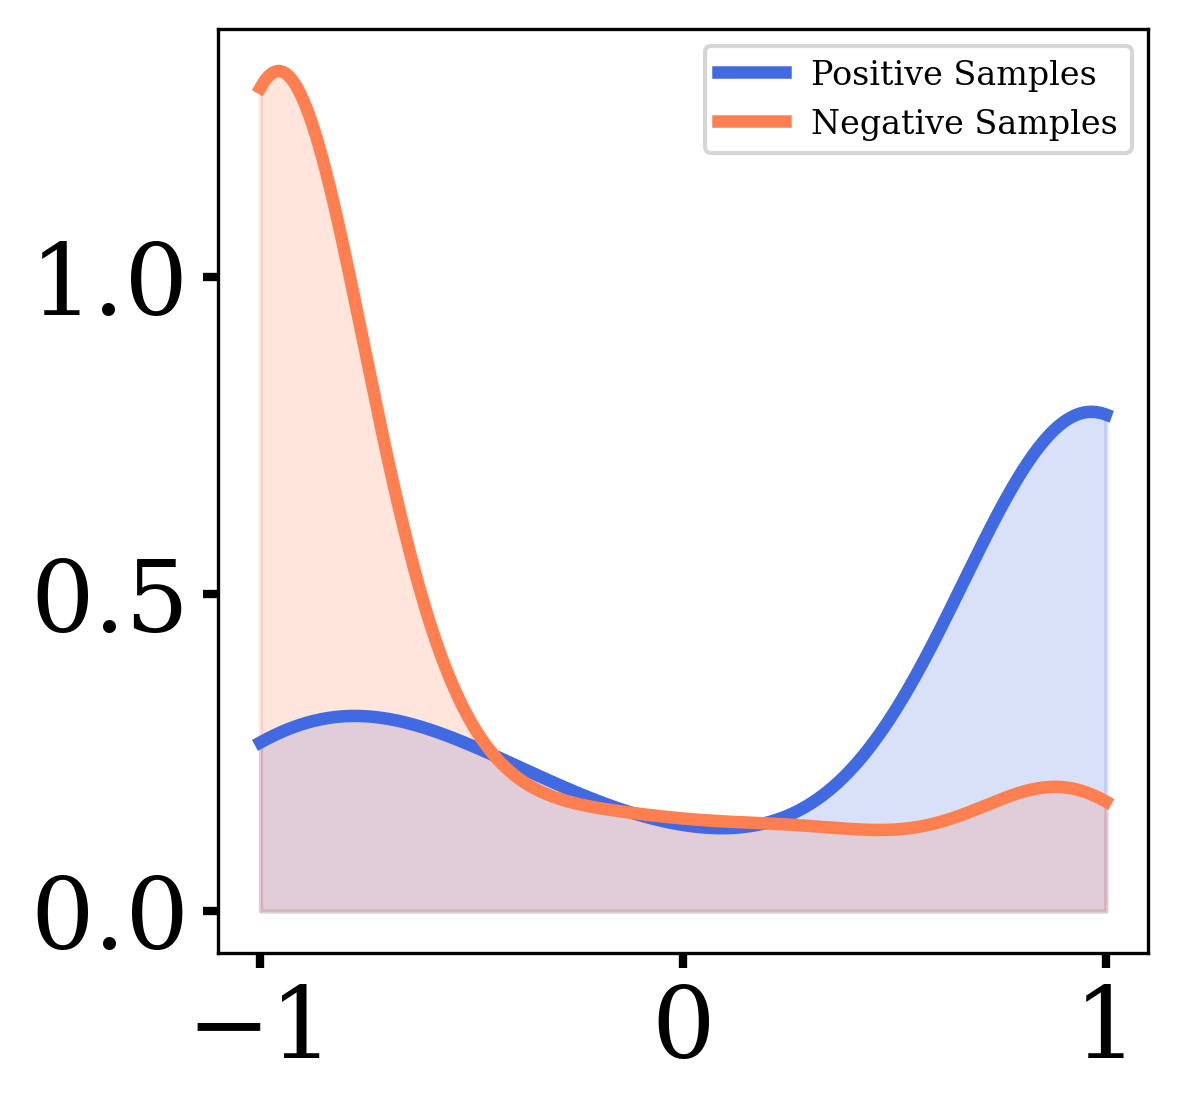

In [52]:
for i in range(len(train_data.label_space)):
    # hidden_results[i][i] = 1
    for j in range(i):
        hidden_distribution_labeli = []
        hidden_distribution_labelj = []
        for res in hidden_set_wrt_label[i]:
            hidden_distribution_labeli.append(res[i] - res[j])
        for res in hidden_set_wrt_label[j]:
            hidden_distribution_labelj.append(res[i] - res[j])
        density1 = gaussian_kde(hidden_distribution_labeli)
        density2 = gaussian_kde(hidden_distribution_labelj)
        x = np.linspace(min(min(hidden_distribution_labeli), min(hidden_distribution_labelj)), 
                        max(max(hidden_distribution_labeli), max(hidden_distribution_labelj)), 500)
        overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
        hidden_results[i][j] = overlap_area
        hidden_for_avg.append(overlap_area)
        
        plt.figure(figsize=(4, 4), dpi=300)
        plt.plot(x, density1(x), 
                 label='Positive Samples', 
                 color='Royalblue',
                 linewidth = 3)
        plt.plot(x, density2(x), 
                 label='Negative Samples', 
                 color='Coral',
                 linewidth = 3)
        plt.fill_between(x, density1(x), 0, color='Royalblue', alpha=0.2)
        plt.fill_between(x, density2(x), 0, color='Coral', alpha=0.2)
        # plt.xlabel("Probability: Pos. - Neg.", fontsize=16)
        # plt.ylabel("Kernel Density", fontsize=20)
        plt.legend(prop = {'size': 8})
        plt.tick_params(width=2, labelsize=24)
        # plt.savefig("Ana1, fig/dist/" + train_data.dataset_name + str(k) + '-' + str(i) + '-' + str(j) + '.png', bbox_inches = 'tight')
        plt.show()

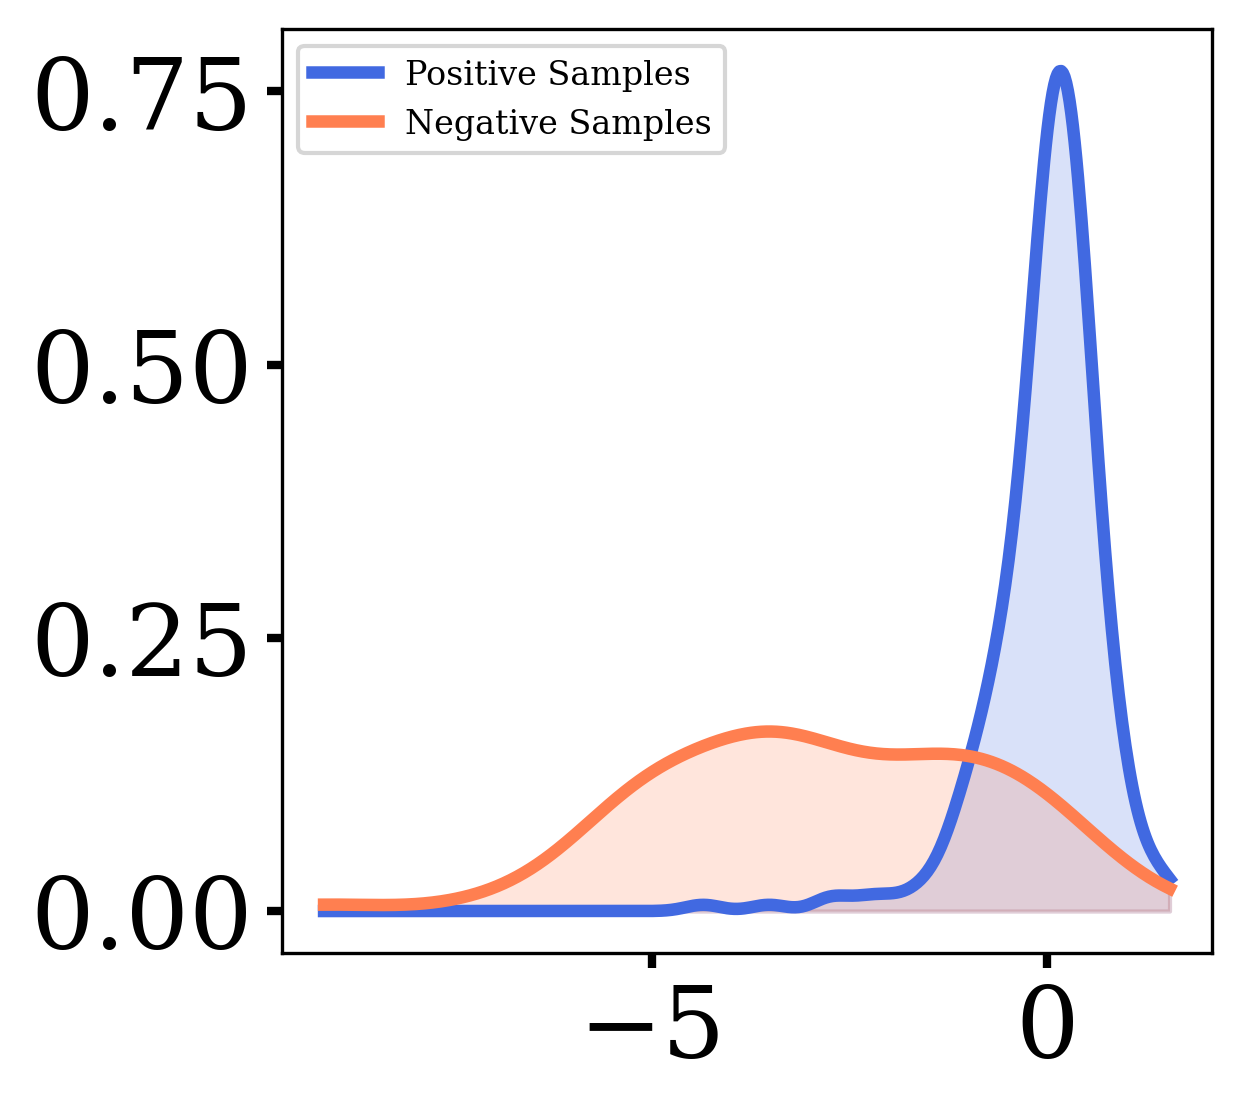

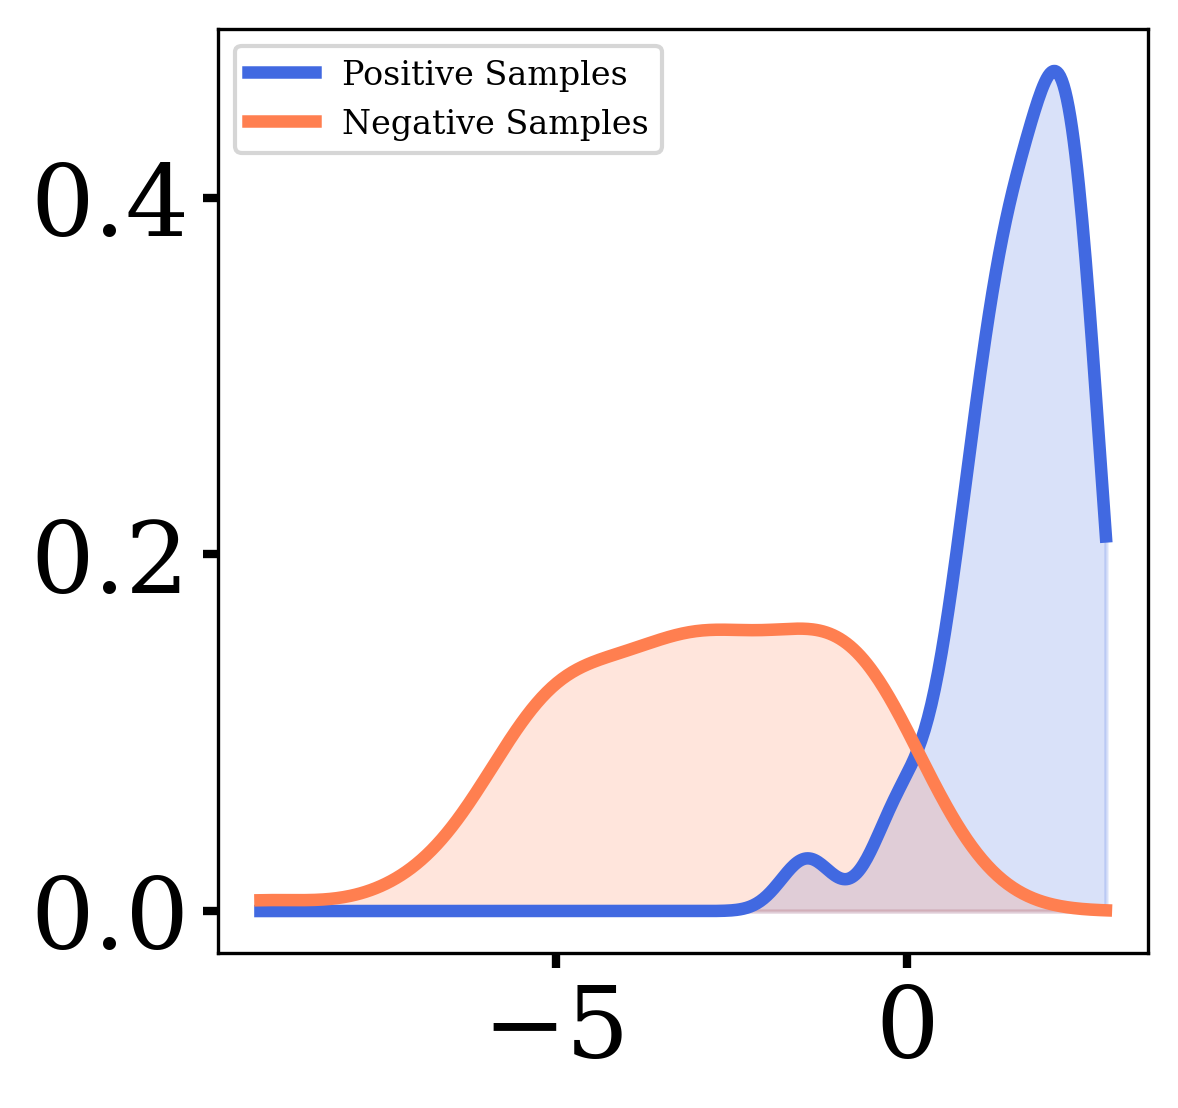

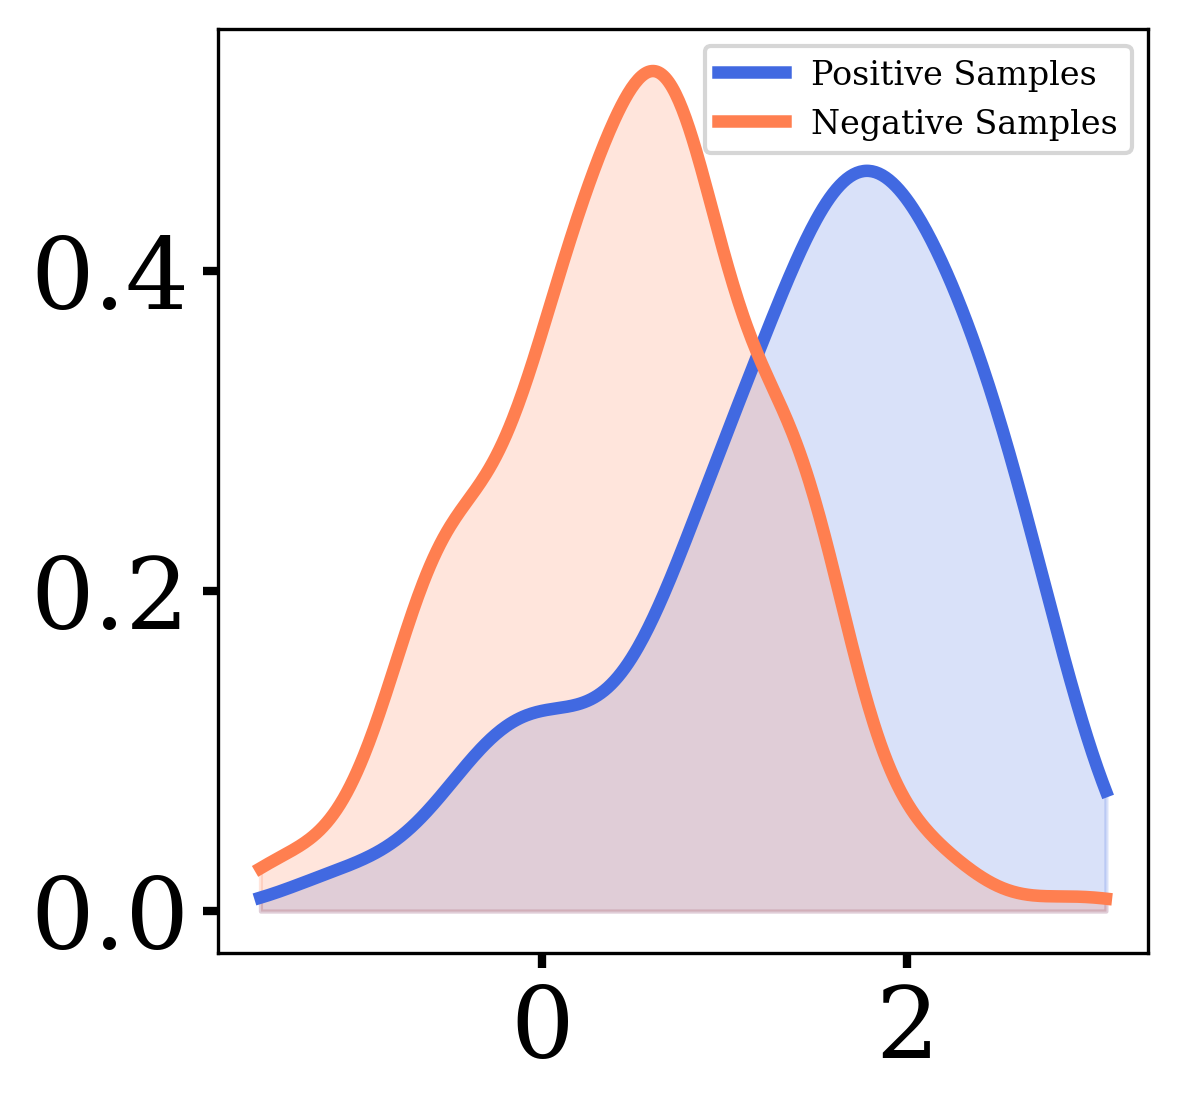

In [53]:
for i in range(len(train_data.label_space)):
    # hidden_results[i][i] = 1
    for j in range(i):
        con_distribution_labeli = []
        con_distribution_labelj = []
        for res in logits_set_wrt_label[i]:
            con_distribution_labeli.append(res[i] / therold_domain[i] - res[j] / therold_domain[j])
        for res in logits_set_wrt_label[j]:
            con_distribution_labelj.append(res[i] / therold_domain[i] - res[j] / therold_domain[j])
        density1 = gaussian_kde(con_distribution_labeli)
        density2 = gaussian_kde(con_distribution_labelj)
        x = np.linspace(min(min(con_distribution_labeli), min(con_distribution_labelj)), 
                        max(max(con_distribution_labeli), max(con_distribution_labelj)), 500)
        overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
        dom_results[i][j] = overlap_area
        dom_for_avg.append(overlap_area)
        
        plt.figure(figsize=(4, 4), dpi=300)
        plt.plot(x, density1(x), 
                 label='Positive Samples', 
                 color='Royalblue',
                 linewidth = 3)
        plt.plot(x, density2(x), 
                 label='Negative Samples', 
                 color='Coral',
                 linewidth = 3)
        plt.fill_between(x, density1(x), 0, color='Royalblue', alpha=0.2)
        plt.fill_between(x, density2(x), 0, color='Coral', alpha=0.2)
        # plt.xlabel("Probability: Pos. - Neg.", fontsize=16)
        # plt.ylabel("Kernel Density", fontsize=20)
        plt.legend(prop = {'size': 8})
        plt.tick_params(width=2, labelsize=24)
        # plt.savefig("Ana1, fig/con/" + train_data.dataset_name + str(k) + '-' + str(i) + '-' + str(j) + '.png', bbox_inches = 'tight')
        plt.show()

# from scipy import spatial

# for i in range(len(train_data.label_space)):
#     # hidden_results[i][i] = 1
#     for j in range(i):
#         hidden_distribution_labeli = []
#         hidden_distribution_labelj = []
#         for res in hidden_set_wrt_label[i]:
#             hidden_distribution_labeli.append(spatial.distance.euclidean(res, hiddenwrtlabels_avg[j]) - spatial.distance.euclidean(res, hiddenwrtlabels_avg[i]))
#         for res in hidden_set_wrt_label[j]:
#             hidden_distribution_labelj.append(spatial.distance.euclidean(res, hiddenwrtlabels_avg[i]) - spatial.distance.euclidean(res, hiddenwrtlabels_avg[j]))
#         density1 = gaussian_kde(hidden_distribution_labeli)
#         density2 = gaussian_kde(hidden_distribution_labelj)
#         x = np.linspace(min(hidden_distribution_labeli), max(hidden_distribution_labelj), 500)
#         overlap_area = np.trapz(np.minimum(density1(x), density2(x)), x)
#         hidden_results[i][j] = overlap_area
#         plt.plot(x, density1(x), label='Data 1')
#         plt.plot(x, density2(x), label='Data 2')
#         plt.fill_between(x, density1(x), density2(x), where=(density1(x) > density2(x)), color='green', alpha=0.3)
#         plt.fill_between(x, density1(x), density2(x), where=(density1(x) < density2(x)), color='red', alpha=0.3)
#         plt.legend()
#         plt.show()

In [54]:
logits_results

[[0, 0, 0],
 [0.4851904062962816, 0, 0],
 [0.15474519413722695, 0.5358518870937501, 0]]

In [55]:
hidden_results

[[0, 0, 0],
 [0.2340370402470776, 0, 0],
 [0.2440687256568717, 0.3865185953545692, 0]]

In [56]:
con_results

[[0, 0, 0],
 [0.2818106914723907, 0, 0],
 [0.14289868936398661, 0.5207822377289848, 0]]

In [57]:
dom_results

[[0, 0, 0],
 [0.2947704744693336, 0, 0],
 [0.14297996556003173, 0.5242343044373006, 0]]

In [58]:
np.mean(logits_for_avg)

0.3919291625090862

In [59]:
np.mean(hidden_for_avg)

0.28820812041950616

In [60]:
np.mean(con_for_avg)

0.3151638728551207

In [61]:
np.mean(dom_for_avg)

0.3206615814888886

In [62]:
print(np.mean(logits_for_avg))
print(np.mean(hidden_for_avg))
print(np.mean(con_for_avg))
print(np.mean(dom_for_avg))

0.3919291625090862
0.28820812041950616
0.3151638728551207
0.3206615814888886


In [63]:
for i in range(len(train_data.label_space)):
    logits_results[i][i] = 1
    hidden_results[i][i] = 1

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'neutral'), Text(0, 2.5, 'positive')]

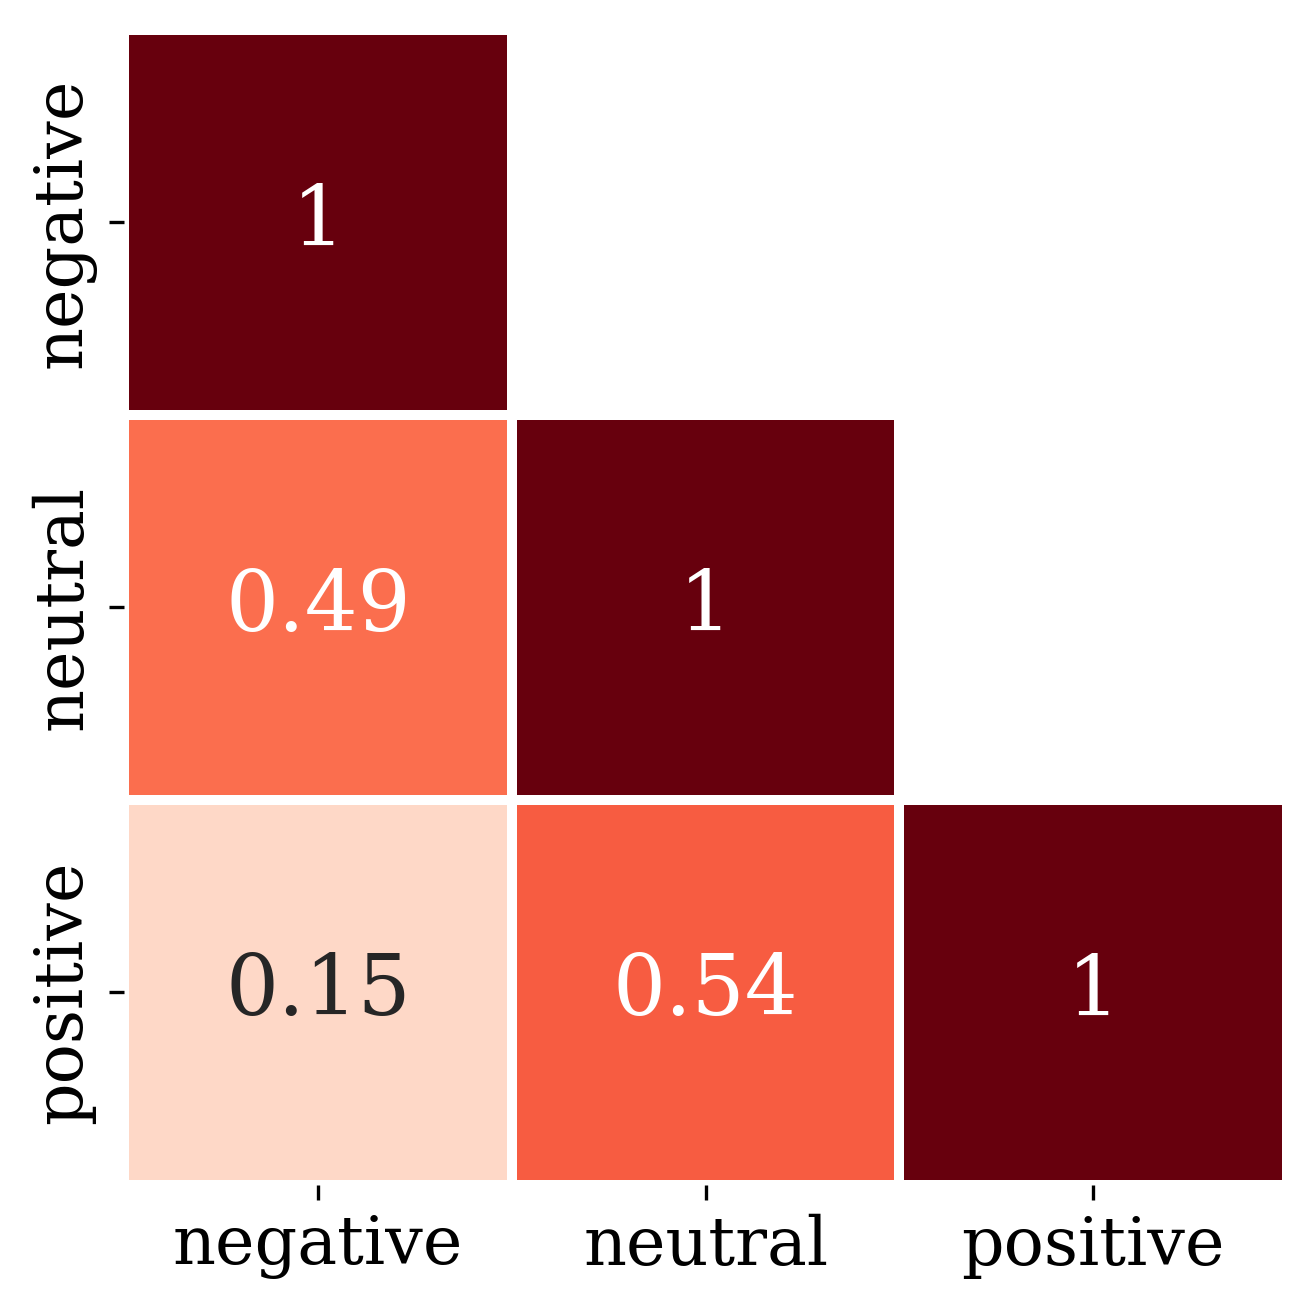

In [64]:
mask = []
for i in range(len(train_data.label_space)):
    temp_mask = [0] * (i+1) + [1] * (len(train_data.label_space)-i-1)
    mask.append(temp_mask)

import seaborn as sns
fig = plt.figure(figsize=(5, 5), dpi=300)
sns.heatmap(
    logits_results, 
    vmin = 0,
    vmax = 1,
    mask = np.array(mask), 
    annot=True, 
    cbar=False,
    linewidths=2,
    cmap = "Reds",
    annot_kws={"fontsize":20}
)
ax=plt.gca()
ax.set_xticklabels(train_data.label_space, fontsize=16)
ax.set_yticklabels(train_data.label_space, fontsize=16)

# from matplotlib.backends.backend_pdf import PdfPages

# pdf = PdfPages("Ana1, fig/direct_" + train_data.dataset_name + str(k) + '.pdf')
# pdf.savefig(bbox_inches='tight', pad_inches = 0.01)
# pdf.close()

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'neutral'), Text(0, 2.5, 'positive')]

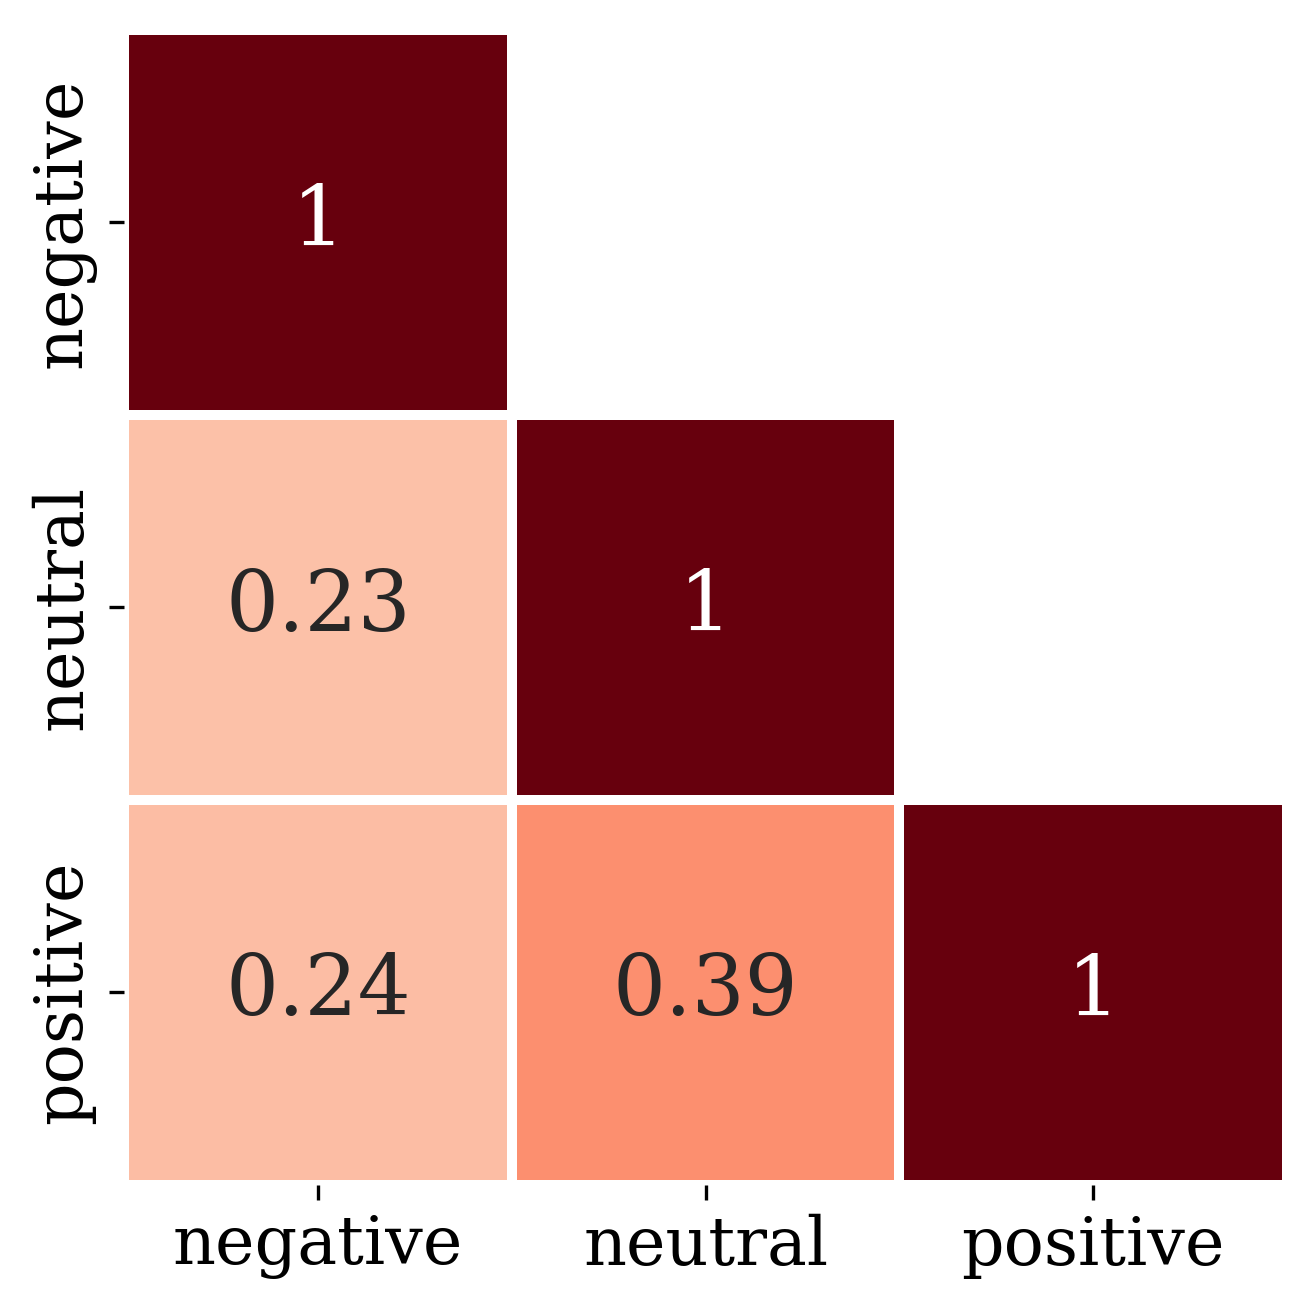

In [65]:
mask = []
for i in range(len(train_data.label_space)):
    temp_mask = [0] * (i+1) + [1] * (len(train_data.label_space)-i-1)
    mask.append(temp_mask)

import seaborn as sns
fig = plt.figure(figsize=(5, 5), dpi=300)
sns.heatmap(
    hidden_results, 
    vmin = 0,
    vmax = 1,
    mask = np.array(mask), 
    annot=True, 
    cbar=False,
    linewidths=2,
    cmap = "Reds",
    annot_kws={"fontsize":20}
)
ax=plt.gca()
ax.set_xticklabels(train_data.label_space, fontsize=16)
ax.set_yticklabels(train_data.label_space, fontsize=16)

# from matplotlib.backends.backend_pdf import PdfPages

# pdf = PdfPages("Ana1, fig/dist_" + train_data.dataset_name + str(k) + '.pdf')
# pdf.savefig(bbox_inches='tight', pad_inches = 0.01)
# pdf.close()

In [66]:
trace = []
for lists in hiddenwrtlabels:
    cova = np.std(np.array(lists), axis=0)
    trace.append(np.mean(cova))
    # cova = np.sqrt(cova)
    # trace.append(cova.trace())

In [67]:
np.mean(trace)

0.63432825

In [68]:
np.cov(np.concatenate(hiddenwrtlabels).T).trace()

2239.84245370735

In [69]:
np.mean(logits_for_avg)

0.3919291625090862

In [70]:
np.mean(hidden_for_avg)

0.28820812041950616